In [1]:
# 데이터 로드
import gdown
file_id = '1EMmSiot45KKtt5OpqKPbfbEri-5T6q6w'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'data.zip', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1EMmSiot45KKtt5OpqKPbfbEri-5T6q6w
To: /content/data.zip
100%|██████████| 2.60M/2.60M [00:00<00:00, 35.2MB/s]


'data.zip'

In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: nsmc_train_label.npy    
  inflating: nsmc_test_input.npy     
  inflating: nsmc_test_label.npy     
  inflating: nsmc_train_input.npy    


In [3]:
import numpy as np

In [5]:
input_data = np.load('/content/nsmc_train_input.npy')
label_data = np.load('/content/nsmc_train_label.npy')

In [6]:
input_data

array([[  463,    20,   265, ...,     0,     0,     0],
       [  604,     1,   219, ...,   969,   680,    24],
       [  393,  2456, 25028, ...,     2,   226,    13],
       ...,
       [   60,  1458,  5612, ..., 10480, 10415,  1050],
       [ 1046,     1,  2271, ...,  1231,   545,  7862],
       [    1,  1806,    22, ...,    63,  1290,     1]], dtype=int32)

In [7]:
# 데이터 분리 학습용 검증용
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,v_val = train_test_split(input_data, label_data, test_size=0.2, random_state=42)

In [31]:
# 하이퍼 파라메터
model_name = 'cnn_classifier_kr'
batch_size = 128
num_epochs = 5
learning_rate = 0.001
max_len = x_train.shape[1]
vocab = 45000
kargs = {'model_name': model_name,
         'vocab': vocab,
         'max_len': max_len,
         'batch_size': batch_size,
         'num_epochs': num_epochs,
         'num_filters' : 100,
         'dropout_rate' : 0.5,
         'hidden_dim' : 250,
         'output_dim' : 1,
         'lr' : learning_rate}

In [30]:
x_train.max()

43756

In [34]:
import tensorflow as tf
class CNN_Classfier(tf.keras.Model):
  def __init__(self, **kargs):
    super(CNN_Classfier, self).__init__()
    # 임베딩의 입력값은 학습데이터의 인덱스의 최대값보다 커야한다.인덱스는 단어의 인덱스
    self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab'], output_dim=100)
    self.conv_list = [tf.keras.layers.Conv1D(filters=kargs['num_filters'],
                                             kernel_size=kernel_size, padding='valid', activation='relu')
                                              for kernel_size in [3,3,3] ]
    self.pooling = tf.keras.layers.MaxPool1D()
    self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
    # kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.) 가중치를 이전상태와 비스하게 만들어서 과적합을 방지
    self.fc1 = tf.keras.layers.Dense(units=kargs['hidden_dim'], activation='relu',
                                     kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    self.fc2 = tf.keras.layers.Dense(units=kargs['output_dim'], activation='sigmoid',
                                     kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
  def call(self, x):
    x = self.embedding(x)
    x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)  # axis=-1 마지막 축을 기준으로 붙인다
    x = tf.keras.layers.Flatten()(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [35]:
# 모델정의
model = CNN_Classfier(**kargs)
# 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=kargs['lr']),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
# 콜벡(필요시)
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint(filepath='./best_model.keras', monitor='val_loss', save_best_only=True)]
# 모델학습
history = model.fit(x_train, y_train,
                    batch_size=kargs['batch_size'], epochs=kargs['num_epochs'],
          validation_data=(x_val, v_val), callbacks=callbacks
                    )
# 평가
x_test = np.load('/content/nsmc_test_input.npy')
y_test = np.load('/content/nsmc_test_label.npy')
model.load_weights('./best_model.keras')
model.evaluate(x_test, y_test)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 74s 76ms/step - accuracy: 0.7609 - loss: 0.4734 - val_accuracy: 0.8219 - val_loss: 0.3899
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 78s 72ms/step - accuracy: 0.8774 - loss: 0.2880 - val_accuracy: 0.8185 - val_loss: 0.4023
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - accuracy: 0.9309 - loss: 0.1768 - val_accuracy: 0.8101 - val_loss: 0.4854
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - accuracy: 0.9594 - loss: 0.1049 - val_accuracy: 0.8043 - val_loss: 0.6725
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8234 - loss: 0.3910


[0.39328625798225403, 0.8223000168800354]

In [36]:
import kagglehub
import pandas as pd
# Download latest version
path = kagglehub.dataset_download("quora/question-pairs-dataset")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/quora/question-pairs-dataset/versions/2


In [38]:
from glob import glob
file_path = glob(path+'/*.csv')
print(file_path)
train_data = pd.read_csv(file_path[0])
train_data.head()

['/root/.cache/kagglehub/datasets/quora/question-pairs-dataset/versions/2/questions.csv']


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [77]:
# 데이터의 개수
train_data['is_duplicate'].value_counts()

,count
is_duplicate,
0,255045
1,149306


In [42]:
# 학습용데이터셋 question1 + question2  -> train_set
train_data_notna = train_data.dropna()

113877

In [49]:
train_data_notna.loc[:,'question1'] = train_data_notna['question1'].astype(str)
train_data_notna.loc[:,'question2'] = train_data_notna['question2'].astype(str)

In [80]:
# axis : {0/'index', 1/'columns'}, default 0
train_set = pd.concat([train_data_notna['question1'] , train_data_notna['question2']])
# 총 데이터개수
# 중복된  데이터 개수
print(f'총 데이터의 수 : {len(train_data_notna)}')
print(f'총 질문의 수 : {len(train_set)}')
print(f'반복해서 나타나는 질문의 수 : {train_set.duplicated().sum()}')

총 데이터의 수 : 404348
총 질문의 수 : 808696
반복해서 나타나는 질문의 수 : 271310


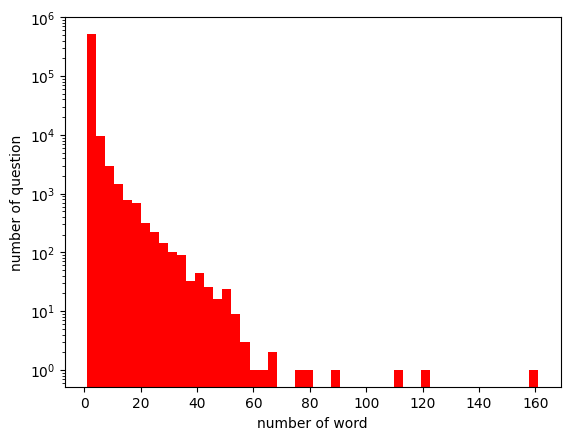

In [87]:
# 중복 질문수가 있으면 시각화 - 히스토그램 분포확인하는 용도 X
import matplotlib.pyplot as plt
plt.hist(train_set.value_counts(),bins=50,color='r',label='word')
plt.ylabel('number of question')
plt.yscale('log')
plt.xlabel('number of word')
plt.show()

In [88]:
# 중복된 데이터는 value_counts()
# 최대 최소 평균 표준편차 중위수
train_set.value_counts().describe()

,count
count,537386.000000
mean,1.504870
std,1.911658
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,161.000000


<Axes: xlabel='is_duplicate'>

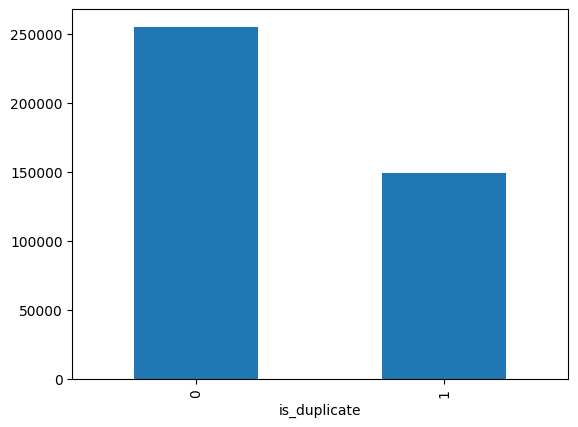

In [90]:
# 불균형 확인  is_duplicate
train_data_notna['is_duplicate'].value_counts().plot(kind='bar')

- 데이터 전처리

In [1]:
import kagglehub
import pandas as pd
# Download latest version
path = kagglehub.dataset_download("quora/question-pairs-dataset")
print("Path to dataset files:", path)

100%|██████████| 20.8M/20.8M [00:00<00:00, 48.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/quora/question-pairs-dataset/versions/2


In [2]:
from glob import glob
filepath = glob(path+'/**/*', recursive=True)[0]

In [3]:
df = pd.read_csv(filepath)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# 특수문자 제거
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
# 특수문자 제거하는 정규식
import re
pattern = f'[{re.escape(string.punctuation)}]'
# 1
print( re.sub(pattern, '', 'Hello, world!') )

# 2
re_pattern = re.compile(pattern)
print( re_pattern.sub('', 'Hello, world!') )


Hello world
Hello world


In [6]:
train_pos_data = df[df['is_duplicate'] == 1]
train_neg_data = df[df['is_duplicate'] == 0]
# 두개 데이터의 차이
class_diff = len(train_neg_data) - len(train_pos_data)
print(class_diff)
# 샘플링 편향을 보이기때문에.. 0, 1 질문의 비율에 따라 샘플링 비율계산
# (class_diff / len(train_neg_data)) 비중복 질문에대한 중복질문의 비율
sample_frac =1 - (class_diff / len(train_neg_data))  # 비중복 질문의 개수를 줄여서 클래스 균형을 맞춤
print(sample_frac)
train_neg_data = train_neg_data.sample(frac=sample_frac)  # 비율에 따라서 비 중복 질문 데이터를 샘플링 - undersample과 유사

105739
0.5854104177694133


In [7]:
len(train_pos_data), len(train_neg_data)

(149306, 149306)

In [8]:
# 합치기
train_data = pd.concat([train_pos_data, train_neg_data])

In [9]:
train_data = train_data.reset_index(drop=True)

In [10]:
train_data = train_data.dropna()

In [11]:
filterred_question1 = train_data['question1'].apply(lambda x: re.sub(pattern, '', x))
filterred_question2 = train_data['question2'].apply(lambda x: re.sub(pattern, '', x))

In [12]:
filterred_question1 = filterred_question1.apply(lambda x: x.lower())
filterred_question2 = filterred_question2.apply(lambda x: x.lower())

In [14]:
import tensorflow as tf
import numpy as np
# Tokenizer : 패딩작업(동일한크기), 빈도기반 인덱싱 --> 딥러닝 모델의 데이터로 인기
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer() # 숫자 시퀀스로 변환 이 데이터는 딥러닝 모델에 입력할수 있는 형태로 변
tokenizer.fit_on_texts(filterred_question1 + filterred_question2)

question1_sequence = tokenizer.texts_to_sequences(filterred_question1)
question2_sequence = tokenizer.texts_to_sequences(filterred_question2)
# 길이를 맞춰준다
# padding='post' 시퀀스의 끝에 추가
q1_data = tf.keras.preprocessing.sequence.pad_sequences(question1_sequence, maxlen=31,padding='post')
q2_data = tf.keras.preprocessing.sequence.pad_sequences(question2_sequence, maxlen=31,padding='post')
# 딕셔너리 단어인덱스와 패딩토큰을 저장
word_vocab = {}
word_vocab = tokenizer.word_index
word_vocab['<PAD>'] = 0  # 패딩토큰을 위한 인덱스, 구분자 , 다른인덱스 충돌

labels = np.array(train_data['is_duplicate'], dtype=int)

In [15]:
# 환경변수를 저장할 json파일을 생성
data_config = {}
data_config['vocab'] = word_vocab
data_config['vocab_size'] = len(word_vocab)

train_q1_data = 'train_q1.npy'
train_q2_data = 'train_q2.npy'
train_label_data = 'train_label.npy'
data_configs = 'data_configs.json'

np.save(train_q1_data, q1_data)
np.save(train_q2_data, q2_data)
np.save(train_label_data, labels)

import json
json.dump(data_config, open(data_configs, 'w'))

- 머신러닝 VS 딥러닝(LSTM, CNN)

In [ ]:
# XGBoost

In [16]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [17]:
# 데이터 가져오기
train_q1_data = np.load('/content/train_q1.npy')
train_q2_data = np.load('/content/train_q2.npy')
train_label_data = np.load('/content/train_label.npy')
train_input = np.stack((train_q1_data,train_q2_data),axis=1)  # 데이터를 두번째 차원에서 쌍이도록 설정
train_q1_data.shape,train_q2_data.shape, train_input.shape  # (298609, 2, 31)
# 두개의 입력을 요구하는 모델에 쉽게 적용하기위해서 모양을 맞춤
# 두개의 질문쌍을 나타내는 단일구조를 생성, 길이도 동일, cnn, rnn계열에 적용

((298612, 31), (298612, 31), (298612, 2, 31))

In [18]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[7,8,9],[10,11,12]])
c = np.stack((a,b),axis=1)
print(c.shape)
c

(2, 2, 3)


array([[[ 1,  2,  3],
        [ 7,  8,  9]],

       [[ 4,  5,  6],
        [10, 11, 12]]])

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_input, train_label_data, test_size=0.2, random_state=42)

In [20]:
x_train.shape

(238889, 2, 31)

In [21]:
#1 머신러닝
import xgboost as xgb
# 각행을 합쳐서 1D 배열을 생성, 각 질문쌍의 벡터를 합쳐서 하나의 벡터로 변환
tain_data = xgb.DMatrix(data=x_train.sum(axis=1), label=y_train)
eval_data = xgb.DMatrix(data=x_val.sum(axis=1), label=y_val)
# 두 개의 데이터를 튜플로 묶어
data_list = [(tain_data, 'train'), (eval_data, 'valid')]
xgb_model = xgb.train(params={
          'objective': 'binary:logistic',  # 이진분류
          'eval_metric': 'rmse'
        },
          dtrain=tain_data,
          num_boost_round=1000,  # 1000번의 반복을 통해 모델을 훈련
          evals=data_list,
          early_stopping_rounds=10)

[0]	train-rmse:0.48399	valid-rmse:0.48418
[1]	train-rmse:0.47333	valid-rmse:0.47405
[2]	train-rmse:0.46655	valid-rmse:0.46731
[3]	train-rmse:0.46195	valid-rmse:0.46289
[4]	train-rmse:0.45818	valid-rmse:0.45932
[5]	train-rmse:0.45525	valid-rmse:0.45663
[6]	train-rmse:0.45336	valid-rmse:0.45494
[7]	train-rmse:0.45198	valid-rmse:0.45361
[8]	train-rmse:0.45056	valid-rmse:0.45236
[9]	train-rmse:0.44966	valid-rmse:0.45152
[10]	train-rmse:0.44775	valid-rmse:0.44995
[11]	train-rmse:0.44723	valid-rmse:0.44949
[12]	train-rmse:0.44410	valid-rmse:0.44657
[13]	train-rmse:0.44315	valid-rmse:0.44576
[14]	train-rmse:0.44281	valid-rmse:0.44549
[15]	train-rmse:0.44206	valid-rmse:0.44488
[16]	train-rmse:0.44180	valid-rmse:0.44468
[17]	train-rmse:0.44113	valid-rmse:0.44409
[18]	train-rmse:0.44057	valid-rmse:0.44374
[19]	train-rmse:0.43941	valid-rmse:0.44272
[20]	train-rmse:0.43920	valid-rmse:0.44259
[21]	train-rmse:0.43859	valid-rmse:0.44217
[22]	train-rmse:0.43845	valid-rmse:0.44206
[23]	train-rmse:0.438

In [22]:
preds = xgb_model.predict(eval_data)
preds = [1 if data > 0.5 else 0 for data in preds ]
from sklearn.metrics import accuracy_score
# 0~1 사이의 확률값이고 실제 정답은 0 1 이기때문에
# Classification metrics can't handle a mix of binary and continuous targets
print(accuracy_score(y_val, preds))

0.7369187750113022


- CNN
- LSTM

In [23]:
import json
train_q1_data = np.load('/content/train_q1.npy')
train_q2_data = np.load('/content/train_q2.npy')
train_label_data = np.load('/content/train_label.npy')
prepro_configs = json.load(open('/content/data_configs.json','r'))

In [24]:
prepro_configs['vocab_size']

158937

In [25]:
train_q1_data.shape[1]

31

In [26]:
# 모델  하이퍼 파라메터
model_name = 'cnn_classifier_kr'
batch_size = 128
num_epochs = 5
learning_rate = 0.001
max_len = train_q1_data.shape[1]
kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'],
         'word_embedding_dim': 100,
         'conv_num_filters': 300,
         'conv_window_size':3,
         'max_pool_seq_len': max_len,
         'sent_embedding_dimension' : 128,
         'dropout_rate': 0.2,
         'hidden_dimension': 200,
         'output_dimension': 1}

In [27]:
# 모델 생성
# 문장 두개, cnn 기반의 유사도모델을 구현 두개의 질문쌍을 비교 두개가 중복된 질문인지 아닌지를 예측
# 임베딩 클래스
class SentenceEmbedding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SentenceEmbedding, self).__init__()
        self.conv = tf.keras.layers.Conv1D(kwargs['conv_num_filters'],kargs['conv_window_size']
                                           ,activation = tf.keras.activations.relu,padding = 'same')
        self.max_pool = tf.keras.layers.MaxPool1D(kargs['max_pool_seq_len'],1)
        self.dense = tf.keras.layers.Dense(kargs['sent_embedding_dimension'],activation='relu')
    def call(self,x):
      x = self.conv(x)
      x = self.max_pool(x)
      x = self.dense(x)
      return tf.squeeze(x,1)  # 차원이 1인 축을 제거해서 최종 임베딩 벡터를 반환


In [28]:
# 두 문장의 유사도를 계산하는 딥러닝 모델 정의
# 두 문장의 임베딩을 생성- 비교 - 유사성을 이진분류형태로 예측하는 구조
class SentenceSimilarity(tf.keras.Model):
  def __init__(self, **kwargs):
    super(SentenceSimilarity, self).__init__()
    self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab_size'], # 단어의 총 개수(어휘 크기)
                                                output_dim=kargs['word_embedding_dim']) # 임베딩 하는 벡터의 차원 수
    self.base_encoder = SentenceEmbedding(**kargs) # 첫번재 문장
    self.hyp_encoder = SentenceEmbedding(**kargs) # 두번재 문장
    self.dense = tf.keras.layers.Dense(kargs['hidden_dimension'],activation='relu')
    self.logit = tf.keras.layers.Dense(1,activation='sigmoid')  # 0~1사이의 확률값을 반환
    self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])
  def call(self, x):
    x1, x2 = x
    b_x = self.embedding(x1)
    h_x = self.embedding(x2)
    b_x = self.dropout(b_x)
    h_x = self.dropout(h_x)

    b_x = self.base_encoder(b_x) # 문장의 특징 벡터로 변환
    h_x = self.hyp_encoder(h_x) # 문장의 특징 벡터로 변환

    e_x = tf.concat([b_x,h_x],axis=-1)  # 마지막 차원을 기준으로 결합
    e_x = tf.keras.layers.Flatten()(e_x) # 2차원을 1차원으로 변환
    e_x = self.dense(e_x)
    e_x = self.dropout(e_x)
    return self.logit(e_x)


In [36]:
train_q1_data,train_q2_data
train_label_data
x1_train,x1_test,x2_train,x2_test,y1_train,y2_test = \
 (train_test_split(train_q1_data,train_q2_data,train_label_data,test_size=0.2,random_state=42))

In [37]:
x1_train.shape,x1_test.shape,x2_train.shape,x2_test.shape,y1_train.shape,y2_test.shape

((238889, 31), (59723, 31), (238889, 31), (59723, 31), (238889,), (59723,))

In [38]:
model = SentenceSimilarity(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
history = model.fit( (x1_train,x2_train),y1_train,batch_size= batch_size,epochs=num_epochs,
          validation_split=0.1)

Epoch 1/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.6976 - loss: 0.5653 - val_accuracy: 0.7658 - val_loss: 0.4766
Epoch 2/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8284 - loss: 0.3799 - val_accuracy: 0.7855 - val_loss: 0.4590
Epoch 3/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9075 - loss: 0.2269 - val_accuracy: 0.7843 - val_loss: 0.5224
Epoch 4/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9502 - loss: 0.1279 - val_accuracy: 0.7822 - val_loss: 0.6249
Epoch 5/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9684 - loss: 0.0841 - val_accuracy: 0.7776 - val_loss: 0.7623


In [39]:
preds = model.predict((x1_test,x2_test))

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [41]:
preds = [1 if data>0.5 else 0 for data in preds]

In [43]:
accuracy_score(y2_test, preds)

0.7753126936021298

- LSTM 모델적용

In [69]:
# LSTM 문장의 시퀀스 정보를 추출한다음 두 문장의 벡터간의 거리를 계산해서 유사도를 반환하는 방식
class Lstm_Classifier(tf.keras.Model):
  def __init__(self, **kargs):
    super(Lstm_Classifier, self).__init__()
    self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab_size'], # 단어의 총 개수(어휘 크기)
                                                output_dim=kargs['word_embedding_dim'])
    self.lstm = tf.keras.layers.LSTM(kargs['hidden_dimension'],return_sequences=False)  # return_sequences=True 모든 시퀀스의 출력을 반환
  def call(self, x):
    x1,x2 = x
    x1 = self.embedding(x1)
    x2 = self.embedding(x2)
    x1 = self.lstm(x1)
    x2 = self.lstm(x2)
    # 유사도 계산 두 문장벡터의 절대값의 차이를 계산 합계
    # 축소해서 합계를 구한다
    # tf.exp(- .. 맨허튼거리 의 음수를 취해 지수함수를 적용 -- 두 문장의 거리가 클수록 값이 작아지게, 작을수록 유사도가 커지게
    x = tf.exp(  -tf.reduce_sum( tf.abs(x1-x2),axis=1 )  )
    return x

In [57]:
# 2D 텐서
a = tf.constant([[[1,2],[3,4],[5,6]],[[10,20],[30,40],[50,60]]])
print(a.shape)
result = tf.reduce_sum(a, axis=(0,2))
result.shape

(2, 3, 2)


TensorShape([3])

In [60]:
type(x1_train)

numpy.ndarray

In [70]:
model = Lstm_Classifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
callbacks  = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='./best_model.keras', monitor='val_loss', save_best_only=True)
]
history = model.fit( (x1_train,x2_train),y1_train,batch_size= batch_size,epochs=num_epochs,
          validation_split=0.1, callbacks=callbacks)

Epoch 1/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.0160 - loss: 0.6263 - val_accuracy: 0.0321 - val_loss: 0.4772
Epoch 2/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - accuracy: 0.0122 - loss: 0.4171 - val_accuracy: 0.0267 - val_loss: 0.4607
Epoch 3/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.0127 - loss: 0.3639 - val_accuracy: 0.0267 - val_loss: 0.4571
Epoch 4/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.0170 - loss: 0.3290 - val_accuracy: 0.0267 - val_loss: 0.4628
Epoch 5/5
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.0160 - loss: 0.2972 - val_accuracy: 0.0267 - val_loss: 0.4583


In [71]:
# 베스트 모델 로드
model.load_weights('./best_model.keras')
# 평가
preds = model.predict((x1_test,x2_test))
preds = [1 if data>0.5 else 0 for data in preds]
accuracy_score(y2_test, preds)

1867/1867 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


0.7918557339718366

In [176]:
(filterred_question1 + filterred_question2)[0]

'astrology i am a capricorn sun cap moon and cap risingwhat does that say about meim a triple capricorn sun moon and ascendant in capricorn what does this say about me'

In [177]:
question1_sequence[0]

[2565, 3, 74, 5, 11414, 982, 5450, 892, 11, 5450, 34131, 21, 26, 240, 45, 64]

In [181]:
tokenizer.word_index['i']

3

In [183]:
sample = 'i am a boy boy is hansome'
sample_dict = {}
# 빈도수
for word in sample.split():
  if word not in sample_dict:
    sample_dict[word] = 1
  else:
    sample_dict[word] += 1
print(sample_dict)
# 단어의 고유 인덱스
sample_dict = {}
count = 1
for word in sample.split():
  if word not in sample_dict:
    sample_dict[word] = count
    count += 1
print(sample_dict)

{'i': 1, 'am': 1, 'a': 1, 'boy': 2, 'is': 1, 'hansome': 1}
{'i': 1, 'am': 2, 'a': 3, 'boy': 4, 'is': 5, 'hansome': 6}


In [184]:
# 토크나이져 : 딥러닝에 유리, 텍스트 분류, 감성분석, 번역등
# 카운트벡터 : 빈도에따라서 벡터화 -> 고차원데이터  분류,군집화 등등 머신러닝등.... 주로 문서의 특성추출